In [1]:
from ensembles import VanillaEnsemble, BootstrapEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two types of ensembles, Vanilla Network Ensemble with different initialisation parameters and Bootstrap Ensemble grown by presenting copies of the exact same model with different subsets of the dataset.

All underlying Estimators are built in tensorflow (1.4) and are based on the same parent object (ToDo: Make this more beautiful and readable). Can be found in /estimators. The Ensembles simulate Online Training rather than actually training online at the moment (ToDo: Rewrite Ensembles to train online properly). The Code can be found in /ensembles.

VanillaEnsemble, which is an ensemble of the class EnsembleNetwork that differ in two significant ways: 
    1. different number of layers 
    2. different initial conditions (translates to different seeds at weight initialisation time)
    3. each of the networks are shown the full dataset
Inspired by an approach used in [1]

    
   
BootstrapEnsemble, which is an ensemble of the class EnsembleNetwork in which each part of the ensemble:
    1. share the exact same hyperparameters
    2. share the same initial conditions (translates to setting the same seed at weight initialisation time)
    3. are each shown  ~ 50% of the Dataset
Expansion of [2] to (kind of) work with Deep Networks 


No Regularisation has been added, thus quite a bit of overfitting occurs.

ToDo:

- add Dropout Ensemble from [3]





# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), for the Bootstrap network a distribution over parameters can be achieved by assuming that each $w_i$ is a draw from a normal distribution. While thinkable in theory, the same is non-trivial for an ensemble with differing hyperparameters (i.e. different number of layers and different layer sizes).

# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is offline. The datasets are shown to the estimators as a whole (although it should be relatively easy to switch to online) (ToDo: Switch to Online). The Bootstrap in the Bootstrap Estimator is achieved by randomly drawing  sub-datasets that each contain ~ 50% of datapoints.
The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list) (ToDo: solve that)

# Problems/ToDo

It's not entirely clear (ToDo: Literature search) what scaling factor should be used for the variance. While the VanillaEnsemble can to a certain extend be influenced by choosing vastly different models (including untouched hyperparameters such as but not limited to _weight initialisation schemes, optimisation algorithms, learning rate,..._, it's not entirely obvious which hyperparameters apart from the number of estimators $p_{keep}$ that regulates the size of the subsampled datasets can be chosen to generate inherently greater (or lower) variance in the samples.

Hyperparameters need to be tuned

No real Online Training

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)




[1] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474



[2] Eckles, D., & Kaptein, M. (2014). Thompson sampling with the online bootstrap. arXiv preprint arXiv:1410.4009.

Link: https://arxiv.org/abs/1410.4009


[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

# Preparations

In [2]:

from global_vars import SEED as seed
#seed = 
data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

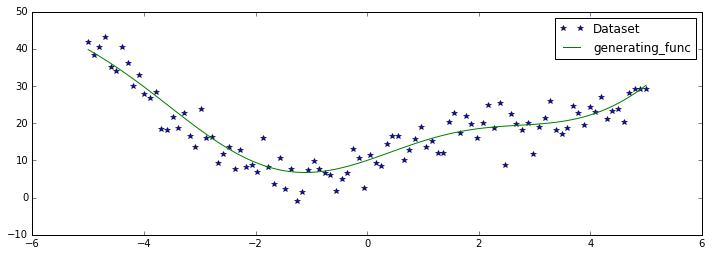

In [3]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Initialise Ensembles

In [4]:
num_epochs = 10
num_eps = 25#100
#ensemble = [{'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10,10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        

ensemble = [{'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,20],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,5],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        
    
    
vanilla = VanillaEnsemble(estimator_stats = ensemble)


#bootstrap_ensemble = {'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}
bootstrap_ensemble = {'num_neurons':[10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}

bootstrap = BootstrapEnsemble(estimator_stats= bootstrap_ensemble)

In [5]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']
    

Vanilla Ensemble already displays a measure of uncertainty due to the ensembled models being initialised differently.
Bootstrap Ensemble does not have uncertainty die to the fact that all contained models are initialised in exactly the same way (thus each sample returns the exact same values)

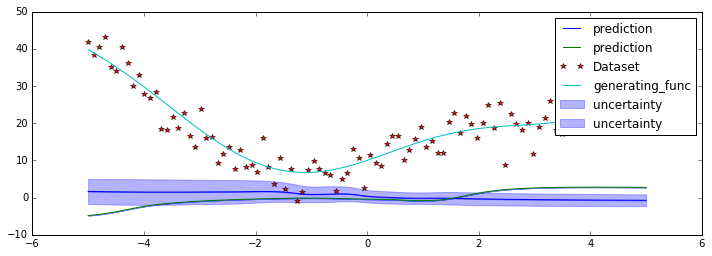

In [6]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var)

plot_prediction(X,
                bootstrap_preds,
                sorted_index,
                bootstrap_var)

plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Training

## Vanilla Ensemble

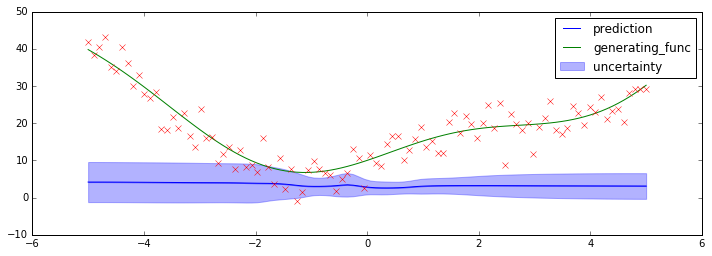

RSME is 17.4172420501709
COVERAGE PROBABILITY is 0.13
MEAN VARIANCE is 3.6294033527374268
COVERAGE/MEAN_VAR is 0.03581855951666252
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40443245, 3.0032576162088278e-05)


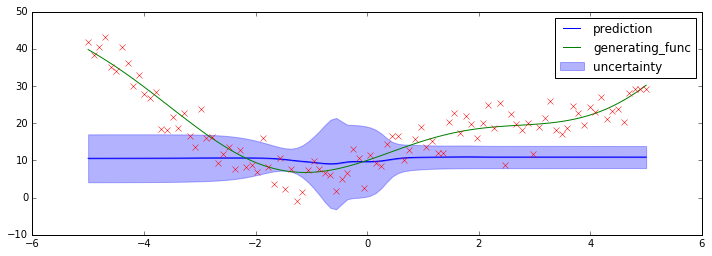

RSME is 12.010249137878418
COVERAGE PROBABILITY is 0.37
MEAN VARIANCE is 4.977575302124023
COVERAGE/MEAN_VAR is 0.07433338072095347
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.068956666, 0.49542284937515912)


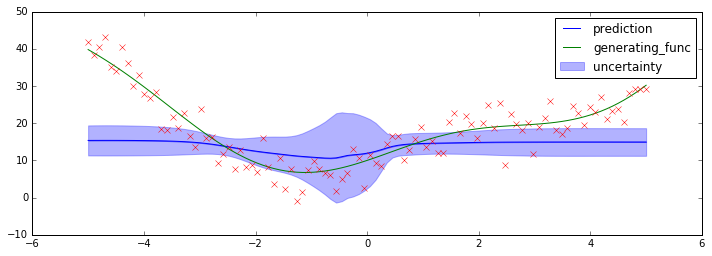

RSME is 9.420031547546387
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 4.4102888107299805
COVERAGE/MEAN_VAR is 0.09749928370990911
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.06171523, 0.54187834482571162)


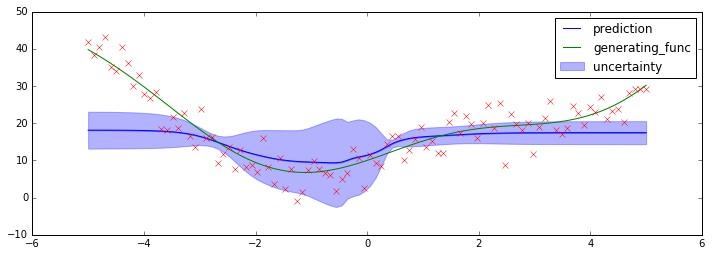

RSME is 7.955496311187744
COVERAGE PROBABILITY is 0.48
MEAN VARIANCE is 4.529297351837158
COVERAGE/MEAN_VAR is 0.10597670294384713
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.040846452, 0.68658221636072048)


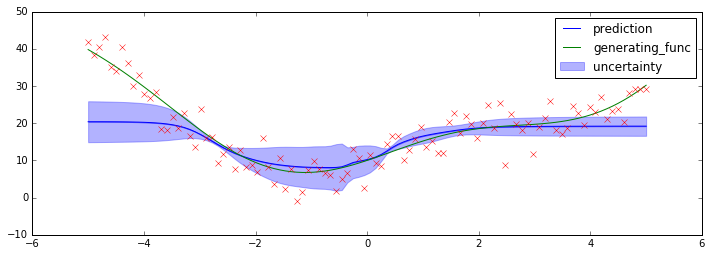

RSME is 6.9301838874816895
COVERAGE PROBABILITY is 0.41
MEAN VARIANCE is 3.126116991043091
COVERAGE/MEAN_VAR is 0.1311531210043407
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.43578741, 5.8499891636713732e-06)


In [7]:
vanilla_error_list = []
for i in range(num_eps):
    vanilla.train(X,y)
    #errors = vanilla.train_and_evaluate(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #vanilla_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        vanilla_pred_dict = vanilla.predict(X)
        vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
        vanilla_var = vanilla_var**2
        plot_prediction(X,vanilla_preds,sorted_index,vanilla_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds,var=vanilla_var)

In [8]:
#plt.plot(np.squeeze(vanilla_error_list))

## Bootstrap Ensemble

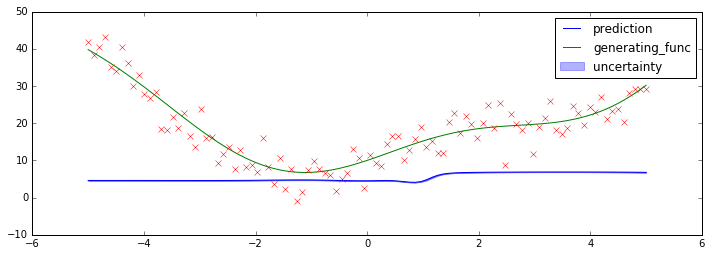

RSME is 15.748568534851074
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.0567937009036541
COVERAGE/MEAN_VAR is 0.0
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.070868701, 0.48351601202257111)


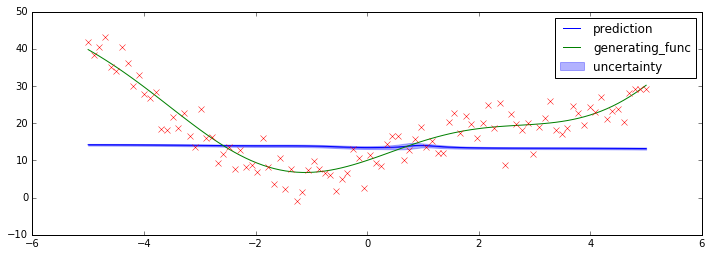

RSME is 10.520833015441895
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 0.3151497542858124
COVERAGE/MEAN_VAR is 0.03173094652306441
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.34319508, 0.00047299477447673797)


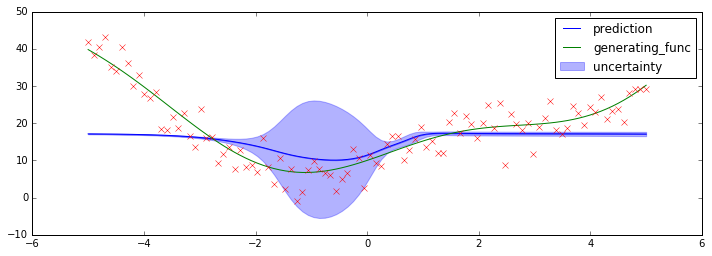

RSME is 8.486201286315918
COVERAGE PROBABILITY is 0.24
MEAN VARIANCE is 2.7756998538970947
COVERAGE/MEAN_VAR is 0.08646468012852287
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16468547, 0.1015573845577946)


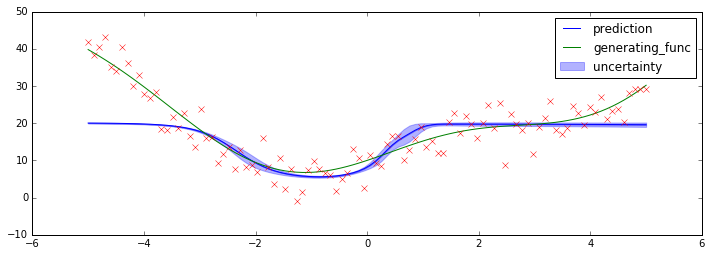

RSME is 7.021274089813232
COVERAGE PROBABILITY is 0.13
MEAN VARIANCE is 0.5524946451187134
COVERAGE/MEAN_VAR is 0.23529639816159154
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.3138262, 0.0014751114276393296)


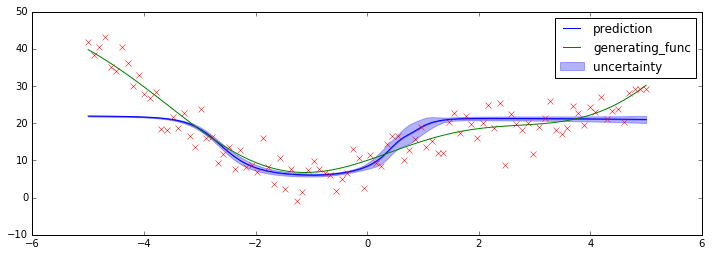

RSME is 6.449162006378174
COVERAGE PROBABILITY is 0.1
MEAN VARIANCE is 0.6743824481964111
COVERAGE/MEAN_VAR is 0.14828381175613783
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.30082887, 0.0023560338244225645)


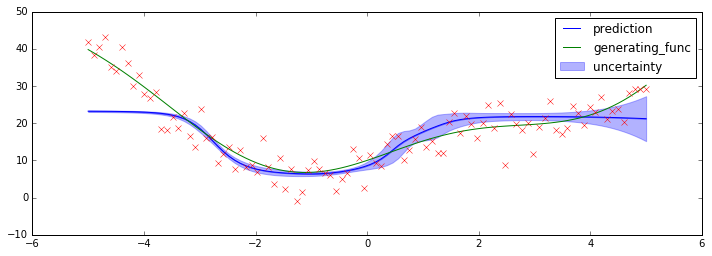

RSME is 6.067143440246582
COVERAGE PROBABILITY is 0.22
MEAN VARIANCE is 1.3197604417800903
COVERAGE/MEAN_VAR is 0.16669691940702847
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.19189194, 0.055798203666139627)


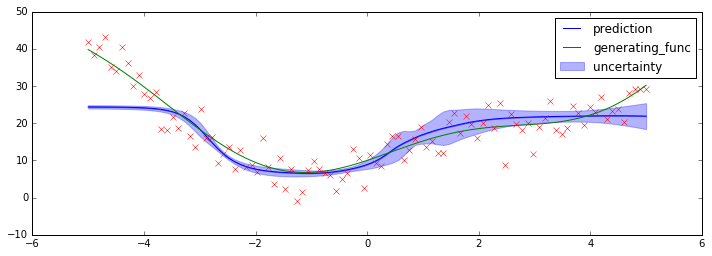

RSME is 5.713503837585449
COVERAGE PROBABILITY is 0.31
MEAN VARIANCE is 1.6583514213562012
COVERAGE/MEAN_VAR is 0.1869326344270756
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.24799043, 0.012856621278158974)


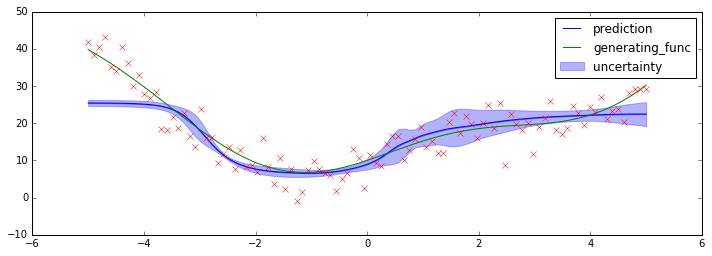

RSME is 5.430833339691162
COVERAGE PROBABILITY is 0.37
MEAN VARIANCE is 1.9266266822814941
COVERAGE/MEAN_VAR is 0.19204550803887407
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.20476088, 0.040995878913532971)


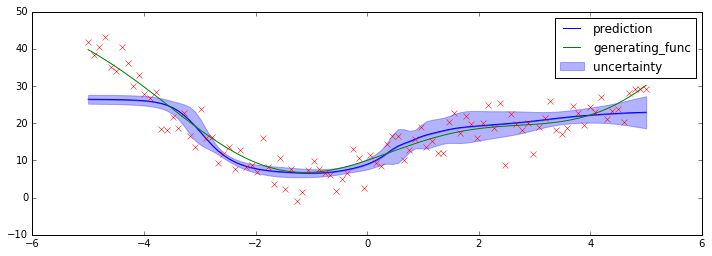

RSME is 5.178046226501465
COVERAGE PROBABILITY is 0.4
MEAN VARIANCE is 2.187957525253296
COVERAGE/MEAN_VAR is 0.18281890547838342
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16123204, 0.10903332449801102)


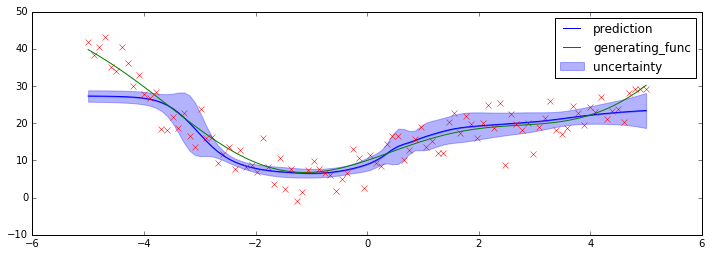

RSME is 4.9614996910095215
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 2.5499277114868164
COVERAGE/MEAN_VAR is 0.19216231024615593
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.1227432, 0.22375397921666951)


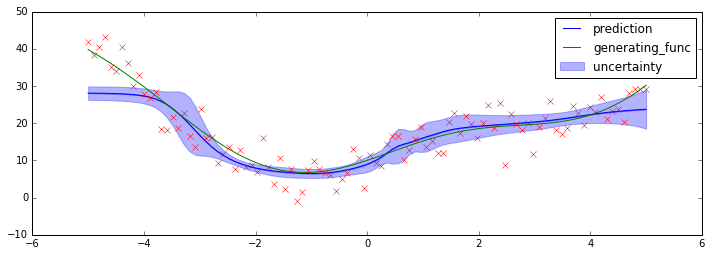

RSME is 4.791012287139893
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 2.5457653999328613
COVERAGE/MEAN_VAR is 0.18462031105159774
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.081773147, 0.41862655262549742)


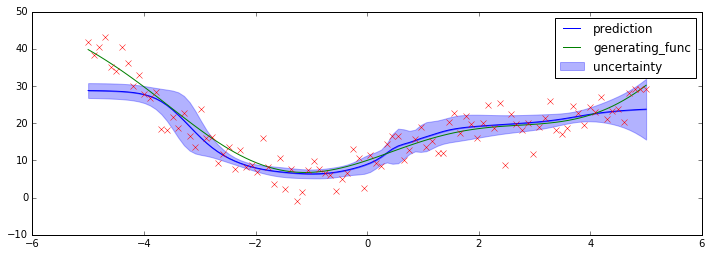

RSME is 4.652055740356445
COVERAGE PROBABILITY is 0.52
MEAN VARIANCE is 2.64426851272583
COVERAGE/MEAN_VAR is 0.19665173846659045
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.028884057, 0.77543832932231638)


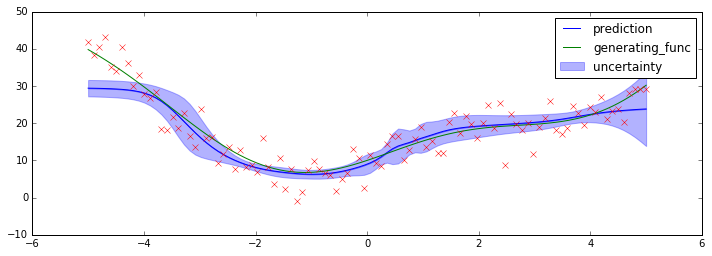

RSME is 4.533720016479492
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 2.821659803390503
COVERAGE/MEAN_VAR is 0.1807446806263408
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.0086439066, 0.93198004550590507)


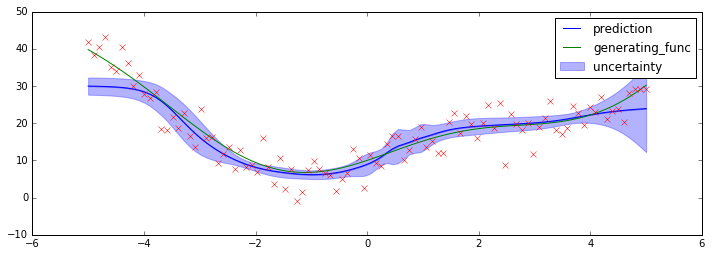

RSME is 4.429431438446045
COVERAGE PROBABILITY is 0.48
MEAN VARIANCE is 2.7300798892974854
COVERAGE/MEAN_VAR is 0.17581903074767363
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.018206442, 0.85731719653877803)


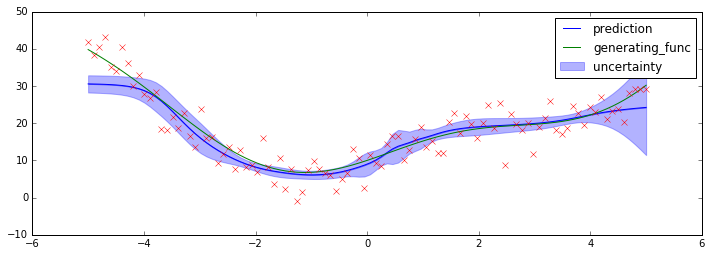

RSME is 4.316076755523682
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 2.6825194358825684
COVERAGE/MEAN_VAR is 0.17520842298962377
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.024979578, 0.80514526918909013)


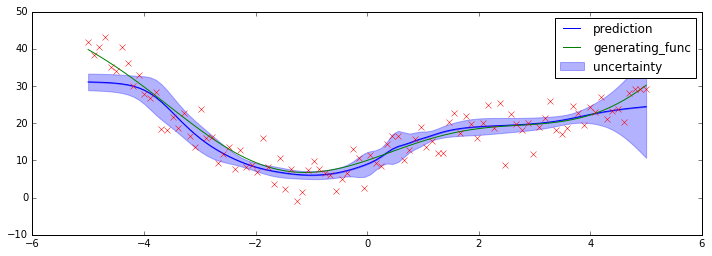

RSME is 4.219950199127197
COVERAGE PROBABILITY is 0.46
MEAN VARIANCE is 2.7277026176452637
COVERAGE/MEAN_VAR is 0.16864008452545423
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.012918027, 0.89849603036279579)


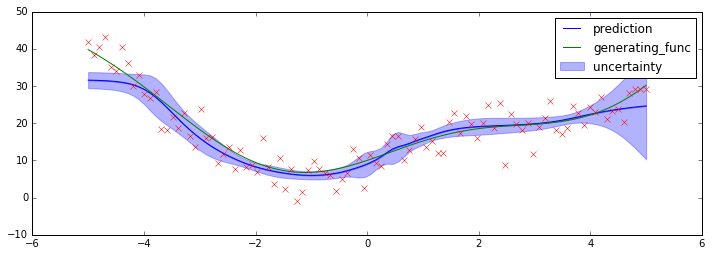

RSME is 4.136367321014404
COVERAGE PROBABILITY is 0.46
MEAN VARIANCE is 2.762826919555664
COVERAGE/MEAN_VAR is 0.16649613363184554
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.0039346525, 0.9690083966119557)


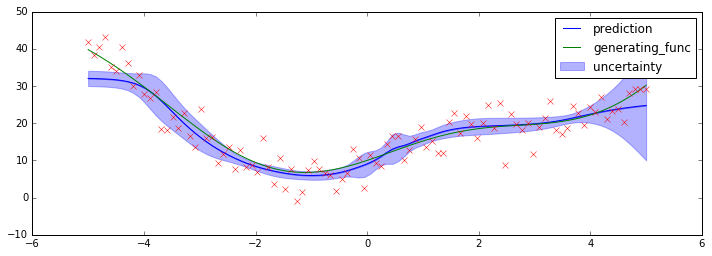

RSME is 4.072861194610596
COVERAGE PROBABILITY is 0.46
MEAN VARIANCE is 2.802058696746826
COVERAGE/MEAN_VAR is 0.16416501215126483
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.0017279655, 0.98638682099593356)


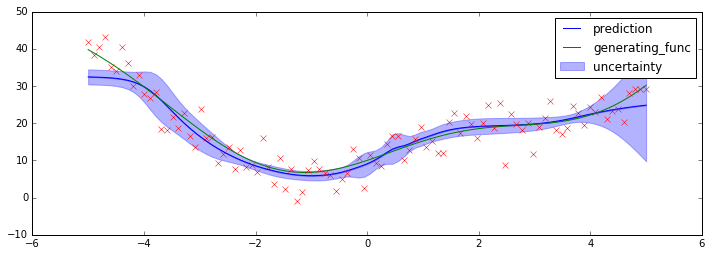

RSME is 4.019140243530273
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 2.879728078842163
COVERAGE/MEAN_VAR is 0.1632098542404637
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.0017062591, 0.98655781173711943)


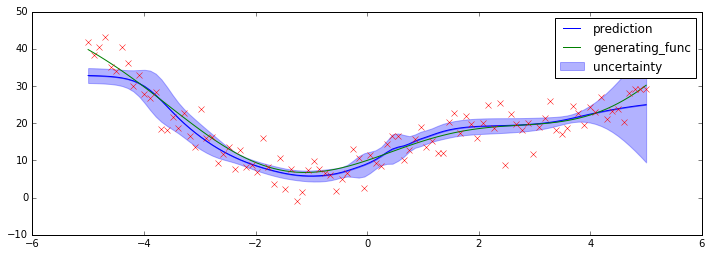

RSME is 3.9641692638397217
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 2.8828439712524414
COVERAGE/MEAN_VAR is 0.16303345053940263
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.0030827001, 0.97571654556501952)


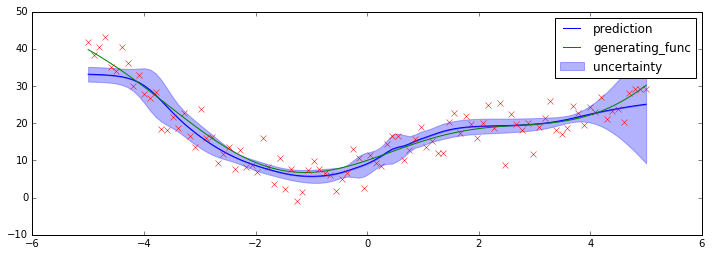

RSME is 3.9150779247283936
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 2.887381076812744
COVERAGE/MEAN_VAR is 0.1627772668368433
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.0088474937, 0.93038195667685397)


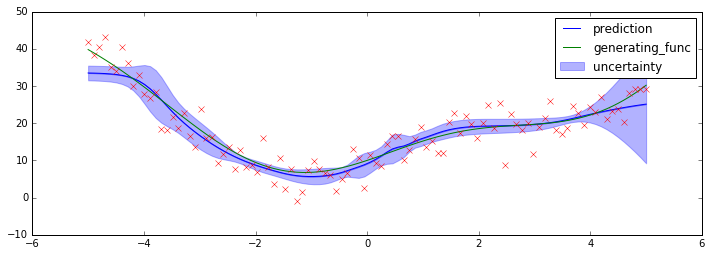

RSME is 3.8814823627471924
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 2.983410120010376
COVERAGE/MEAN_VAR is 0.17094532078553998
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.0015106181, 0.98809898334527446)


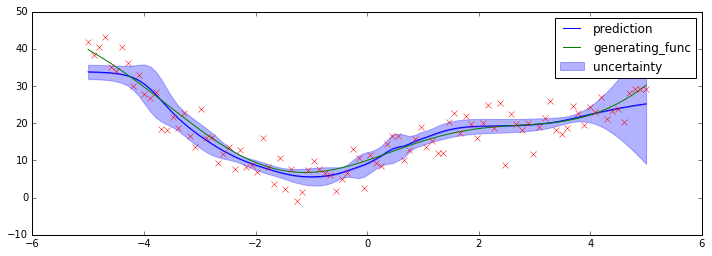

RSME is 3.838573455810547
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 2.9576895236968994
COVERAGE/MEAN_VAR is 0.17243189182431043
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.010134771, 0.92028393278909559)


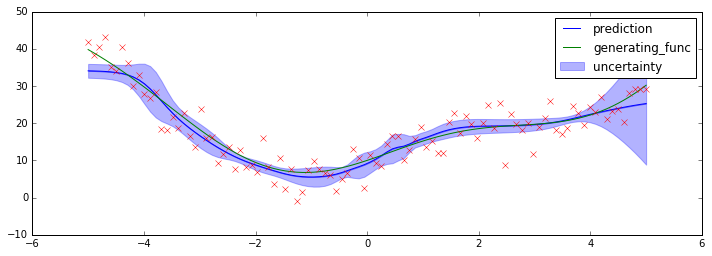

RSME is 3.801680088043213
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 2.9614603519439697
COVERAGE/MEAN_VAR is 0.16883562181468634
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.015027899, 0.88202869602755274)


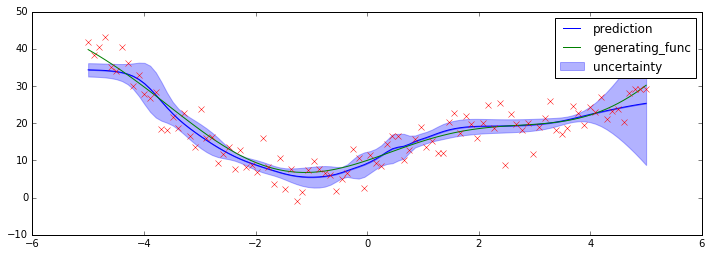

RSME is 3.768306016921997
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 2.9732308387756348
COVERAGE/MEAN_VAR is 0.16816723191459232
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.019286454, 0.84895068152847419)


In [9]:
gauss_error_list = []
for i in range(num_eps*5):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2
        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

# Old Stuff, can probably be deleted, kept for security reasons

In [10]:
vanilla.train(X,y)
bootstrap.train(X,y)

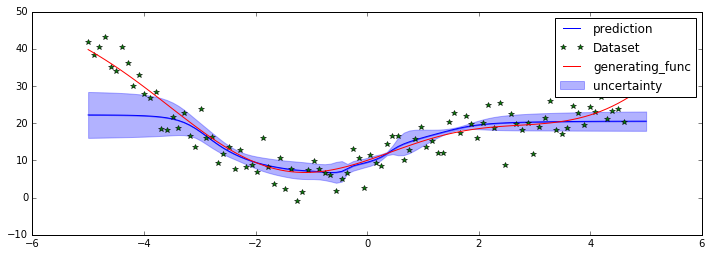

In [11]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var**2)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

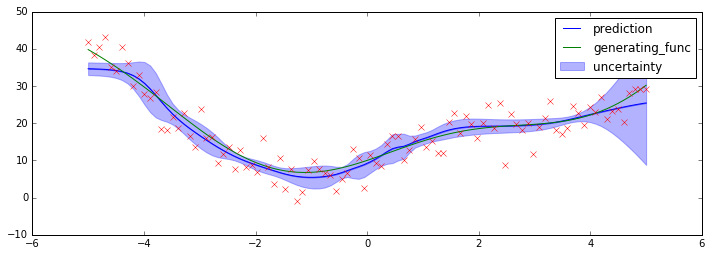

RSME is 3.7318952083587646
COVERAGE PROBABILITY is 0.52
MEAN VARIANCE is 2.987684965133667
COVERAGE/MEAN_VAR is 0.1740478015816288
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.025708701, 0.79957532392751529)


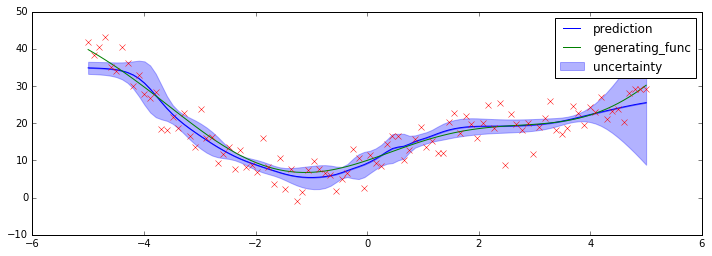

RSME is 3.7049572467803955
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 2.9945547580718994
COVERAGE/MEAN_VAR is 0.16696973019185476
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.030727081, 0.76152460285874646)


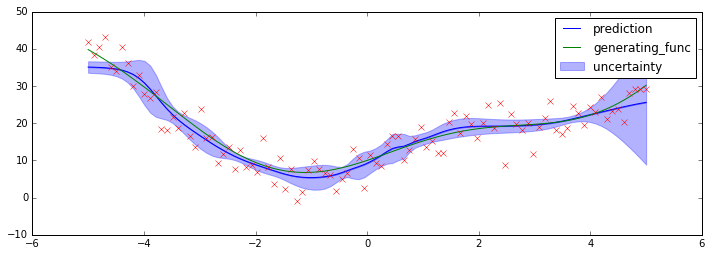

RSME is 3.680424451828003
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 2.996209144592285
COVERAGE/MEAN_VAR is 0.16353998547944412
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.035406251, 0.7265482824226781)


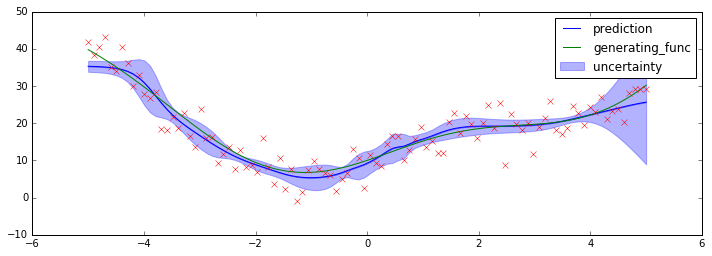

RSME is 3.65755558013916
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 2.993339776992798
COVERAGE/MEAN_VAR is 0.16369675229193967
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.039921604, 0.69331956858182975)


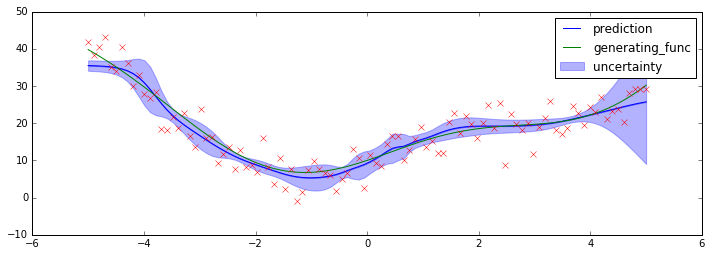

RSME is 3.635390043258667
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 2.9866244792938232
COVERAGE/MEAN_VAR is 0.16406481745433854
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.04425763, 0.66194719534992186)


In [12]:
#gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [13]:
evaluate_model(X,y,vanilla_preds,var=vanilla_var**2)

RSME is 6.266339302062988
COVERAGE PROBABILITY is 0.37
MEAN VARIANCE is 2.5662567615509033
COVERAGE/MEAN_VAR is 0.14417886999599858
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.66895425, 2.8112759043851088e-14)


In [14]:
evaluate_model(X,y,bootstrap_preds,var=bootstrap_var**2)

RSME is 3.635390043258667
COVERAGE PROBABILITY is 0.72
MEAN VARIANCE is 16.098390579223633
COVERAGE/MEAN_VAR is 0.04472496778213484
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.024333732, 0.81008719619091429)


# Hic sunt dracones

In [15]:
from ensembles import GaussianNetworkEnsemble, GaussianLRNetworkEnsemble


In [16]:
gauss = GaussianNetworkEnsemble(estimator_stats = ensemble)

In [17]:
gauss_dict = gauss.predict(X)

In [18]:
mean,std = get_mean_var(gauss_dict)

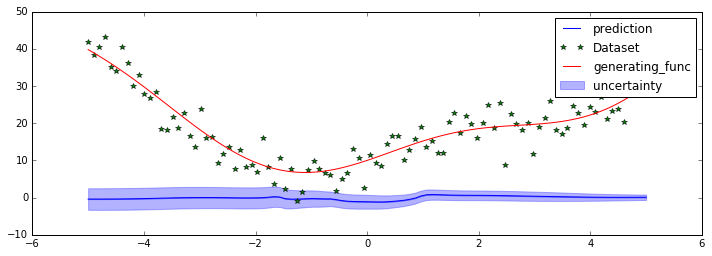

In [19]:
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

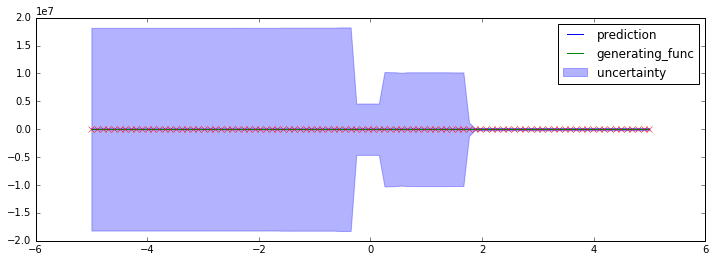

RSME is 54.32925796508789
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 10379012.0
COVERAGE/MEAN_VAR is 9.634828440317825e-08
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.79458922, 5.8264217474388376e-23)


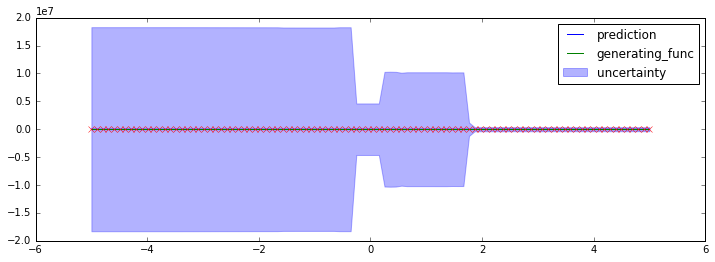

RSME is 47.35643005371094
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 10477940.0
COVERAGE/MEAN_VAR is 9.543860720714186e-08
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.78326273, 6.010550252147535e-22)


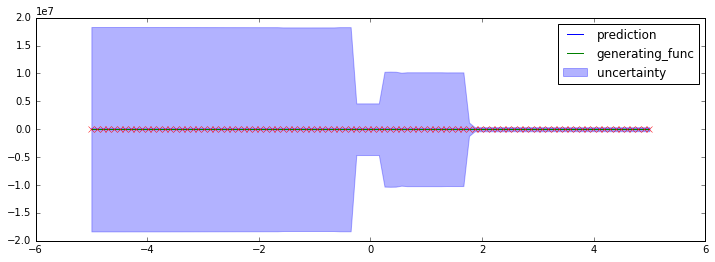

RSME is 38.106685638427734
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 10487789.0
COVERAGE/MEAN_VAR is 9.534898156322557e-08
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.83591151, 2.8104042370473022e-27)


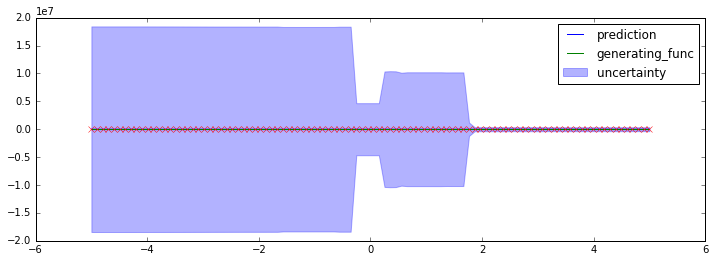

RSME is 73.72704315185547
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 10537050.0
COVERAGE/MEAN_VAR is 9.490322243891791e-08
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.74440235, 6.933550909957434e-19)


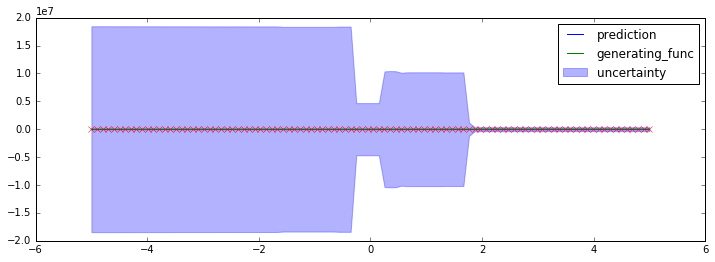

RSME is 63.63888168334961
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 10549622.0
COVERAGE/MEAN_VAR is 9.479012612963764e-08
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.76628953, 1.545563450072829e-20)


In [20]:
#gauss_error_list = []
for i in range(num_eps):
    gauss.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [21]:
gauss.train(X,y)

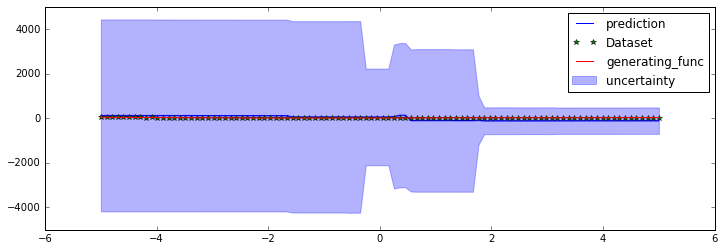

In [22]:
gauss_dict = gauss.predict(X)
mean,std = get_mean_var(gauss_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Learning Rate stuff


In [23]:
gauss_lr = GaussianLRNetworkEnsemble(estimator_stats = ensemble)

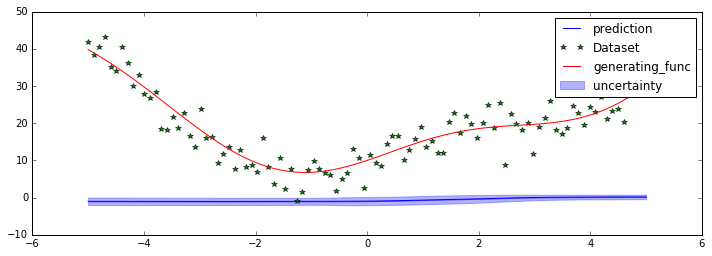

In [24]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

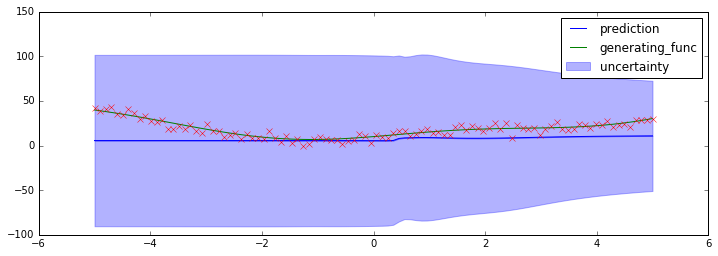

RSME is 14.272710800170898
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 87.5023422241211
COVERAGE/MEAN_VAR is 0.011428265513609735
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.093964368, 0.35242828402689796)


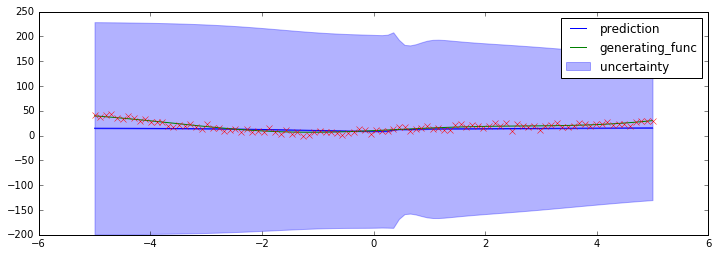

RSME is 9.590669631958008
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 186.47451782226562
COVERAGE/MEAN_VAR is 0.0053626630151854295
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29035759, 0.0033843757291145879)


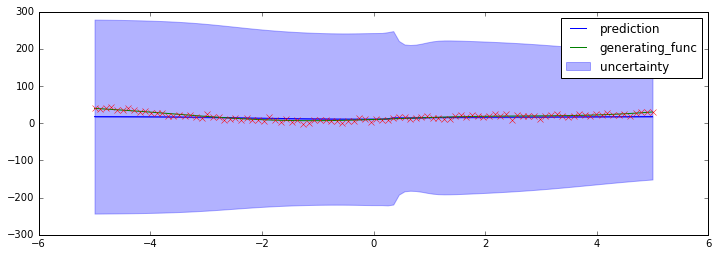

RSME is 8.388651847839355
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 220.52484130859375
COVERAGE/MEAN_VAR is 0.004534636524692651
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38523892, 7.5628384907723534e-05)


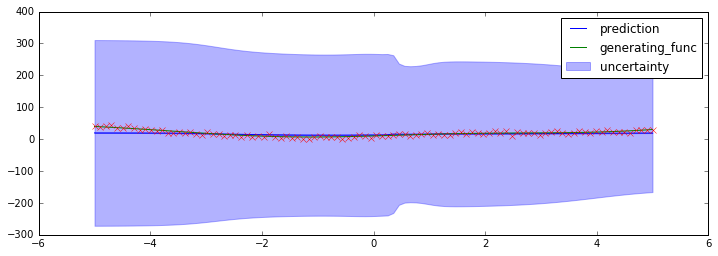

RSME is 7.876328945159912
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 243.3081512451172
COVERAGE/MEAN_VAR is 0.004110014378402657
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.43090037, 7.6311730244028009e-06)


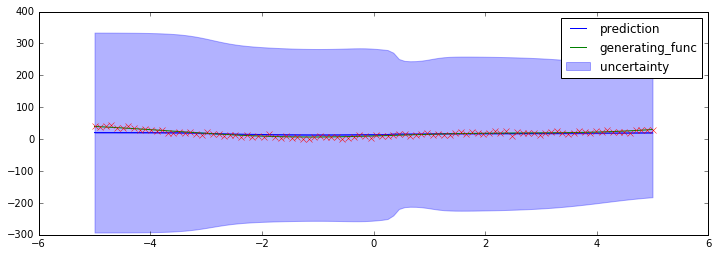

RSME is 7.6546454429626465
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 260.6173095703125
COVERAGE/MEAN_VAR is 0.0038370436777539056
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.45214128, 2.3313527367430659e-06)


In [25]:
#gauss_error_list = []
for i in range(num_eps):
    gauss_lr.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss_lr.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [26]:
gauss_lr.train(X,y)

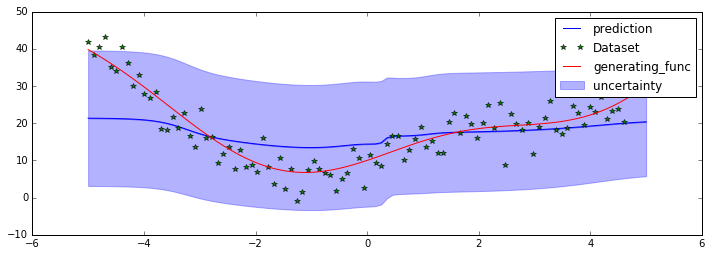

In [27]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)